In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [10]:
if (not "returns_data" in vars()) or (not "riskfree_data" in vars()):
    returns_data = pd.read_excel("../data/Datastream.xlsx", 0)
    riskfree_data = pd.read_excel("../data/FedFundRate.xlsx", 0)

In [11]:
# Read the data
returns = returns_data
# Extract country names and data
countries = returns.iloc[:,0]
returns = returns.iloc[:,1:].T
# Clean up country names
countries = countries.str.split('-').str[0].to_list()
returns.columns = countries
returns.drop("VIETNAM", axis=1, inplace=True)
returns.drop("VENEZUELA", axis=1, inplace=True)
# Read the row headers as dates
returns.index = pd.to_datetime(returns.index)
# Keep only the last day of each month
returns = returns.loc[returns.index.to_series().groupby(returns.index.to_series().dt.to_period("M")).last()]
returns.index = returns.index.to_period("M")

In [12]:
# Clean fed interest rate
riskfree = riskfree_data
riskfree["DATE"] = pd.to_datetime(riskfree["DATE"])
riskfree = riskfree.set_index("DATE")
riskfree.index = riskfree.index.to_period("M")
riskfree = riskfree.reindex(returns.index)
riskfree["FEDFUNDS"] = (riskfree["FEDFUNDS"]/100 + 1)**(1/12) - 1
print(riskfree)

         FEDFUNDS
1988-01  0.005521
1988-02  0.005325
1988-03  0.005325
1988-04  0.005552
1988-05  0.005725
...           ...
2024-06  0.004337
2024-07  0.004337
2024-08  0.004337
2024-09  0.004178
2024-10       NaN

[442 rows x 1 columns]


In [13]:
monthly_returns = returns.ffill().pct_change(fill_method=None)
monthly_excess_returns = monthly_returns.subtract(riskfree["FEDFUNDS"], axis=0)
monthly_excess_returns_pct = monthly_excess_returns*100

In [14]:
mean_monthly_excess_return = monthly_excess_returns.mean()
var_monthly_excess_return = monthly_excess_returns.var()

In [15]:
x = var_monthly_excess_return
y = mean_monthly_excess_return
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
y_pred = model.predict(x)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     20.68
Date:                Thu, 31 Oct 2024   Prob (F-statistic):           2.52e-05
Time:                        20:45:37   Log-Likelihood:                 302.71
No. Observations:                  65   AIC:                            -601.4
Df Residuals:                      63   BIC:                            -597.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.000      9.786      0.0

Text(0.5, 1.0, 'Mean and variance of monthly excess returns in USD')

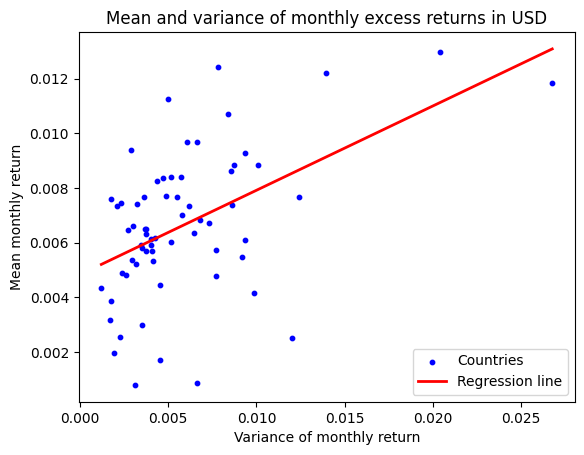

In [16]:
plt.scatter(var_monthly_excess_return, mean_monthly_excess_return, color='blue', s=10, label="Countries")
y_min = y_pred.min()
x_min = var_monthly_excess_return.loc[y_pred.idxmin()]
y_max = y_pred.max()
x_max = var_monthly_excess_return.loc[y_pred.idxmax()]
plt.plot([x_min, x_max], [y_min, y_max], color='red', linewidth=2, label='Regression line')
plt.legend()
plt.xlabel("Variance of monthly return")
plt.ylabel("Mean monthly return")
plt.title("Mean and variance of monthly excess returns in USD")

In [16]:
def convert_annual_to_monthly_return(annual_rate):
    monthly_rate = (annual_rate/100 + 1)**(1/12) - 1

    return monthly_rate

test = pd.Series([100,200])
convert_annual_to_monthly_return(test)

0    0.059463
1    0.095873
dtype: float64